## Assignment A: TinyImagenet training

**A. Target**

1. Download this TINY IMAGENET dataset. 
2. Train ResNet18 on this dataset (70/30 split) for 50 Epochs. Target 50%+ Validation Accuracy. 
3. Submit Results. Of course, you are using your own package for everything. 

**B. Results**

1. Parameters: 11,271,432

2. Best Training Accuracy in 27 epochs: 68.19 % , in 30 epochs 74.99 %

3. Best Test Accuracy in 27 epochs: 54.33 %, in 30 epochs 57.49%


**C. Analysis**


I have used one cycle learninig with max learning rate of 0.02 and minimum of 0.002. Max LR is reached in 11 epochs. I have used augementations (horizontal flip, resizing and random cropping, rotation and cutout with normalization) to regularize the training. Model could acheive required accuracy of above 50% in 24 epochs

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [2]:
import sys
folder = '/content/gdrive/My Drive/EVA5'
sys.path.append(folder)
folder = "/content/gdrive/My Drive/EVA5/Models"
sys.path.append(folder)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import OneCycleLR

import albumentations as A
from collections import Sequence
import numpy as np

from   torch.utils.data import Dataset
import torch.nn.functional as F

In [4]:
rm -r TSAI_EVA5

In [5]:
!git clone https://github.com/SachinDangayach/TSAI_EVA5.git

Cloning into 'TSAI_EVA5'...
remote: Enumerating objects: 579, done.
remote: Total 579 (delta 0), reused 0 (delta 0), pack-reused 579
Receiving objects: 100% (579/579), 14.39 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (314/314), done.


In [6]:
from TSAI_EVA5.session12.dataset import session12_dataset as dataset
from TSAI_EVA5.session12.models import session12_resnet18_model as models
from TSAI_EVA5.session12.models import session12_train_model as train
from TSAI_EVA5.session12.models import session12_test_model as test
from TSAI_EVA5.session9.utils import session9_utils as utils
from TSAI_EVA5.session11.utils import session11_lr_test as lr_test
from TSAI_EVA5.session10.utils import session10_lr_finder as lr_finder
from TSAI_EVA5.session9.utils import session9_view_gradcam as grad_cam

# Extract, Load and Transform Data

In [7]:
norm_mean = (0.442,0.442,0.442)
norm_std = (0.278, 0.278, 0.278)
album_train_transform,album_test_transform = dataset.get_album_transforms(norm_mean,norm_std)

In [8]:
train_dataset , test_dataset,classes = dataset.TinyImageNetDataSet(train_split = 70,train_transforms = album_train_transform,test_transforms = album_test_transform)

Images already downloaded...


In [9]:
# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_dataset,test_dataset,256)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


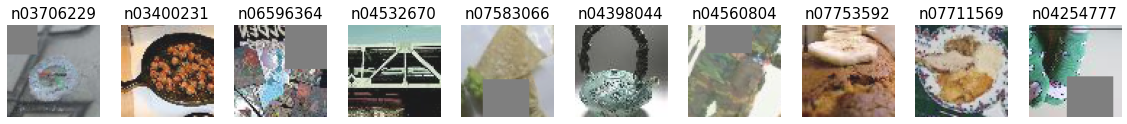

In [10]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Import Model and show model summary

In [11]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

# Set Optimiser, Scheduler, Criterion

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=30, steps_per_epoch=len(train_loader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

## Train and Test Model

In [13]:
train_acc = []
train_loss = []
test_acc = []
test_loss = []
LR = []
best_acc = 0
EPOCHS = 30

for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     LR.append(optimizer.param_groups[0]['lr'])
     train.train(model, device, train_loader, criterion, optimizer, epoch, train_loss, train_acc, scheduler)
     test.test(model, device, test_loader, test_loss, test_acc)

     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/EVA5/bestmodel_s12.pt")

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.002


Loss=4.282223701477051 Batch_id=300 Train Accuracy=5.69: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 4.3027, Test Accuracy: 3221/33000 (9.76%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.0038005982053838485


Loss=3.8348228931427 Batch_id=300 Train Accuracy=13.29: 100%|██████████| 301/301 [08:50<00:00,  1.76s/it]



Test set: Average loss: 3.8234, Test Accuracy: 5329/33000 (16.15%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.005601196410767697


Loss=3.6044015884399414 Batch_id=300 Train Accuracy=19.12: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 3.5925, Test Accuracy: 6473/33000 (19.62%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.007401794616151546


Loss=3.321765184402466 Batch_id=300 Train Accuracy=23.63: 100%|██████████| 301/301 [08:50<00:00,  1.76s/it]



Test set: Average loss: 3.4310, Test Accuracy: 7590/33000 (23.00%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.009202392821535395


Loss=2.9298083782196045 Batch_id=300 Train Accuracy=27.65: 100%|██████████| 301/301 [08:51<00:00,  1.77s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.5035, Test Accuracy: 7459/33000 (22.60%)

EPOCH: 6 LR: 0.011002991026919245


Loss=2.973578453063965 Batch_id=300 Train Accuracy=30.95: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 3.0293, Test Accuracy: 10057/33000 (30.48%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.012803589232303092


Loss=2.8318915367126465 Batch_id=300 Train Accuracy=33.81: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 2.9160, Test Accuracy: 10647/33000 (32.26%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.01460418743768694


Loss=2.571411371231079 Batch_id=300 Train Accuracy=36.15: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.0135, Test Accuracy: 10425/33000 (31.59%)

EPOCH: 9 LR: 0.01640478564307079


Loss=2.50582218170166 Batch_id=300 Train Accuracy=38.51: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 2.8037, Test Accuracy: 11443/33000 (34.68%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 10 LR: 0.01820538384845464


Loss=2.3824336528778076 Batch_id=300 Train Accuracy=40.51: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 2.8394, Test Accuracy: 12065/33000 (36.56%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 11 LR: 0.01999671096345515


Loss=2.3061728477478027 Batch_id=300 Train Accuracy=42.66: 100%|██████████| 301/301 [08:53<00:00,  1.77s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.7709, Test Accuracy: 11897/33000 (36.05%)

EPOCH: 12 LR: 0.01900671096345515


Loss=2.4686858654022217 Batch_id=300 Train Accuracy=44.74: 100%|██████████| 301/301 [08:50<00:00,  1.76s/it]



Test set: Average loss: 2.7821, Test Accuracy: 12308/33000 (37.30%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 13 LR: 0.01801671096345515


Loss=2.1276772022247314 Batch_id=300 Train Accuracy=46.49: 100%|██████████| 301/301 [08:53<00:00,  1.77s/it]



Test set: Average loss: 2.5517, Test Accuracy: 13408/33000 (40.63%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 14 LR: 0.01702671096345515


Loss=2.158343553543091 Batch_id=300 Train Accuracy=48.19: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 2.4427, Test Accuracy: 13817/33000 (41.87%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 15 LR: 0.01603671096345515


Loss=2.187617778778076 Batch_id=300 Train Accuracy=49.64: 100%|██████████| 301/301 [08:53<00:00,  1.77s/it]



Test set: Average loss: 2.4848, Test Accuracy: 14028/33000 (42.51%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 16 LR: 0.01504671096345515


Loss=2.0476503372192383 Batch_id=300 Train Accuracy=51.32: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 2.3459, Test Accuracy: 14718/33000 (44.60%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 17 LR: 0.014056710963455149


Loss=1.9024795293807983 Batch_id=300 Train Accuracy=52.88: 100%|██████████| 301/301 [08:53<00:00,  1.77s/it]



Test set: Average loss: 2.3268, Test Accuracy: 14858/33000 (45.02%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 18 LR: 0.01306671096345515


Loss=2.02685284614563 Batch_id=300 Train Accuracy=54.47: 100%|██████████| 301/301 [08:50<00:00,  1.76s/it]



Test set: Average loss: 2.3362, Test Accuracy: 15015/33000 (45.50%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 19 LR: 0.012076710963455148


Loss=2.0095229148864746 Batch_id=300 Train Accuracy=55.76: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 2.1994, Test Accuracy: 15689/33000 (47.54%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 20 LR: 0.011086710963455149


Loss=1.7325658798217773 Batch_id=300 Train Accuracy=57.47: 100%|██████████| 301/301 [08:51<00:00,  1.77s/it]



Test set: Average loss: 2.1419, Test Accuracy: 16234/33000 (49.19%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 21 LR: 0.010096710963455147


Loss=1.4754365682601929 Batch_id=300 Train Accuracy=58.52: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 2.1049, Test Accuracy: 16440/33000 (49.82%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 22 LR: 0.00910671096345515


Loss=1.6060850620269775 Batch_id=300 Train Accuracy=60.21: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.1643, Test Accuracy: 16121/33000 (48.85%)

EPOCH: 23 LR: 0.008116710963455148


Loss=1.4678436517715454 Batch_id=300 Train Accuracy=61.61: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.2036, Test Accuracy: 15900/33000 (48.18%)

EPOCH: 24 LR: 0.00712671096345515


Loss=1.7020820379257202 Batch_id=300 Train Accuracy=63.08: 100%|██████████| 301/301 [08:50<00:00,  1.76s/it]



Test set: Average loss: 2.0067, Test Accuracy: 17057/33000 (51.69%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 25 LR: 0.006136710963455149


Loss=1.2955293655395508 Batch_id=300 Train Accuracy=64.55: 100%|██████████| 301/301 [08:53<00:00,  1.77s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.1020, Test Accuracy: 16842/33000 (51.04%)

EPOCH: 26 LR: 0.005146710963455148


Loss=1.3270732164382935 Batch_id=300 Train Accuracy=66.36: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 1.9556, Test Accuracy: 17779/33000 (53.88%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 27 LR: 0.00415671096345515


Loss=1.2143646478652954 Batch_id=300 Train Accuracy=68.19: 100%|██████████| 301/301 [08:52<00:00,  1.77s/it]



Test set: Average loss: 1.9085, Test Accuracy: 17930/33000 (54.33%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 28 LR: 0.0031667109634551487


Loss=1.0423476696014404 Batch_id=300 Train Accuracy=70.41: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 1.8629, Test Accuracy: 18326/33000 (55.53%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 29 LR: 0.002176710963455151


Loss=1.0231317281723022 Batch_id=300 Train Accuracy=72.59: 100%|██████████| 301/301 [08:53<00:00,  1.77s/it]



Test set: Average loss: 1.8066, Test Accuracy: 18666/33000 (56.56%)

accuracy increased, Saving model....


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 30 LR: 0.0011867109634551495


Loss=0.9113892912864685 Batch_id=300 Train Accuracy=74.99: 100%|██████████| 301/301 [08:51<00:00,  1.76s/it]



Test set: Average loss: 1.7597, Test Accuracy: 18973/33000 (57.49%)

accuracy increased, Saving model....


## Validation accuracies and Loss change curves

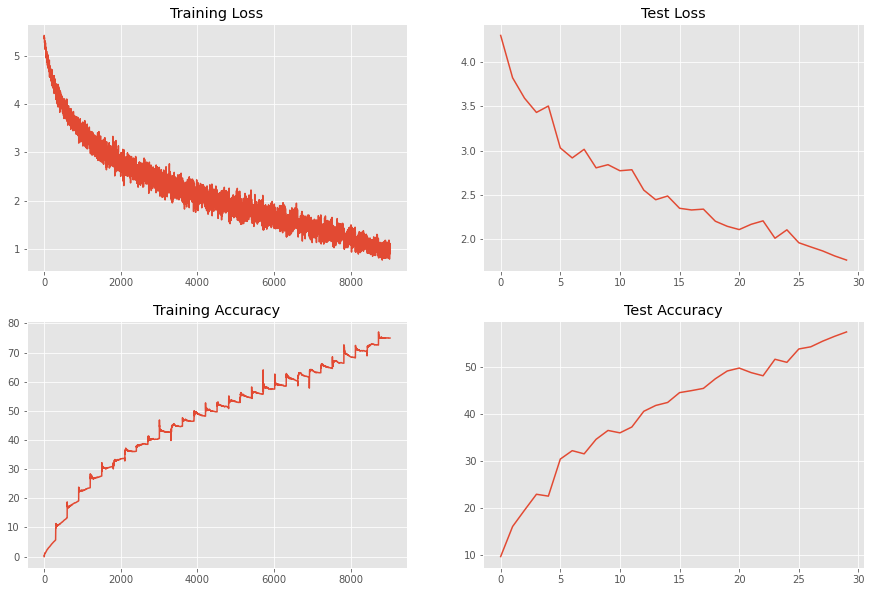

In [14]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)